Purpose: Show why wlasso would fail; Make logistic regression fail

In [181]:
from torch import nn
import copy
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from torchvision import datasets, transforms, utils
from src.utility import convert_image_np
import tqdm
from collections import defaultdict
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import gridspec
from lib.data import Mimic2
from lib.utility import show_tensor_image, show_acc, to_var
from lib.model import MLP
from lib.openbox import open_box, count_config, find_x, open_box_batch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.train import prepareData
from lib.utility import show_tensor_image, show_acc, to_var, modelAP, modelSparsity
from lib.regularization import eye_loss, wlasso, wridge, no_reg
from main import wlasso3, wlasso1_5, wridge3, wridge1_5
from lib.synthetic_data_generation import generate_risk, genCovData
from scipy.linalg import block_diag

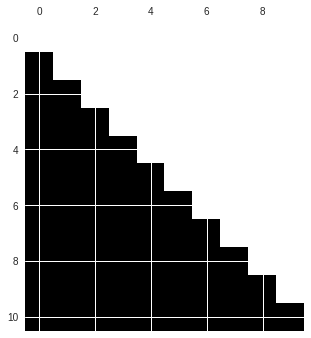

In [123]:
def sweepR(t=1,mu=0,noise=0.05):
    '''t: theta coefficient'''
    nrgroups = 11
    nirgroups = 0
    pergroup = 10
    n = 5000
    # setup
    risk = generate_risk(nrgroups, nirgroups, pergroup, "binary_r")
    # gen data
    base = np.diag(np.ones(pergroup))       
    base[base==0] = 0.99
    C = block_diag(*([base]*(nrgroups+nirgroups)))
    theta = np.zeros((nrgroups + nirgroups) * pergroup)
    theta[:nrgroups*pergroup] = t
    datagen = lambda: genCovData(C=C, theta=theta,
                                 n=n, noise=noise, mu=mu)    
    return datagen, risk

d, risk = sweepR(t=-1, mu=10)
X, y = d()
plt.matshow(risk.reshape(-1, 10))
plt.show()

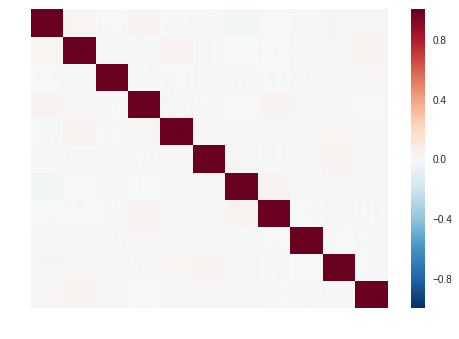

In [124]:
sns.heatmap(np.corrcoef(X.T))
plt.axis('off')
plt.show()

In [177]:
d1, risk = sweepR(t=-1, mu=0, noise=0)
d2, risk = sweepR(t=1, mu=10, noise=0)

X1, y1 = d1()
X2, y2 = d2()

Xtr = np.vstack([X1, X2])
ytr = np.vstack([y1, y2])

X1, y1 = d1()
X2, y2 = d2()

Xte = np.vstack([X1, X2])
yte = np.vstack([y1, y2])

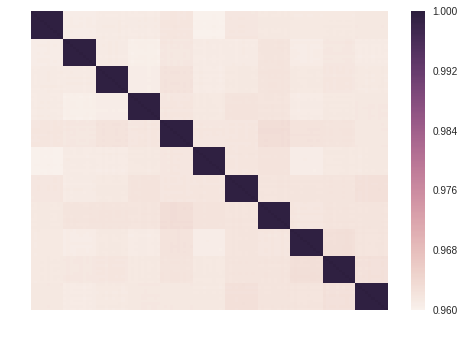

In [178]:
sns.heatmap(np.corrcoef(Xtr.T))
plt.axis('off')
plt.show()

In [179]:
def train(net, trainloader, criterion, optimizer, print_every=None, epochs=1000, max_time=10):
    net.train()
    start = time.time()
    
    # max_time given in seconds
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (x, y) in enumerate(trainloader):
            
            end = time.time()
            if end - start >= max_time:
                print('Finished Training in %ds' % (end-start))                
                return
            
            # get the inputs
            x, y = to_var(x), to_var(y)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(x)
            
            W, b, C = open_box_batch(net, x)
            loss = criterion(outputs, y, W)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data.item()
            if print_every is not None and i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0

    print('Finished Training in %ds' % (end-start))


train_data = TensorDataset(*map(lambda x: x.data, prepareData(Xtr, ytr.reshape(-1))))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)   

test_data = TensorDataset(*map(lambda x: x.data, prepareData(Xte, yte.reshape(-1))))
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)  

risk = to_var(torch.from_numpy(risk)).float()

In [184]:
net = MLP(neuron_sizes=[110, 8, 2])
criterion = no_reg(nn.CrossEntropyLoss(), 0.01, risk)
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
train(net, train_loader, criterion, optimizer, print_every=30, epochs=10, max_time=100)

[1,    30] loss: 0.7129293561
[1,    60] loss: 0.6771474779
[1,    90] loss: 0.6495535751
[1,   120] loss: 0.6107942601
[1,   150] loss: 0.5866683582
[2,    30] loss: 0.5603291750
[2,    60] loss: 0.5548040221
[2,    90] loss: 0.5428986907
[2,   120] loss: 0.5311538597
[2,   150] loss: 0.5074881723
[3,    30] loss: 0.5060259581
[3,    60] loss: 0.4974990149
[3,    90] loss: 0.4875095427
[3,   120] loss: 0.4951030384
[3,   150] loss: 0.4793836753
[4,    30] loss: 0.4743040711
[4,    60] loss: 0.4656829417
[4,    90] loss: 0.4587621152
[4,   120] loss: 0.4580270718
[4,   150] loss: 0.4523786873
[5,    30] loss: 0.4497099002
[5,    60] loss: 0.4404653420
[5,    90] loss: 0.4344747325
[5,   120] loss: 0.4368918727
[5,   150] loss: 0.4297046900
[6,    30] loss: 0.4326977412
[6,    60] loss: 0.4278321246
[6,    90] loss: 0.4128932178
[6,   120] loss: 0.4146789034
[6,   150] loss: 0.4158084184
[7,    30] loss: 0.4151250581
[7,    60] loss: 0.4116618474
[7,    90] loss: 0.4171260118
[7,   120]

In [185]:
show_acc(net, test_loader)
print(modelSparsity(net, test_loader))
print(modelAP(net, test_loader, risk))

Accuracy of the network on 10000  images: 86 %
0.00812909090909
0.526886877319


In [180]:
net = MLP(neuron_sizes=[110, 8, 2])
criterion = eye_loss(nn.CrossEntropyLoss(), 0.01, risk)
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0)
train(net, train_loader, criterion, optimizer, print_every=30, epochs=10, max_time=100)

[1,    30] loss: 0.7521379610
[1,    60] loss: 0.6665331324
[1,    90] loss: 0.6448102891
[1,   120] loss: 0.6172108988
[1,   150] loss: 0.6049611549
[2,    30] loss: 0.5854747891
[2,    60] loss: 0.5787848771
[2,    90] loss: 0.5708054344
[2,   120] loss: 0.5725619853
[2,   150] loss: 0.5567926049
[3,    30] loss: 0.5544509510
[3,    60] loss: 0.5477946877
[3,    90] loss: 0.5352805952
[3,   120] loss: 0.5324247291
[3,   150] loss: 0.5256818920
[4,    30] loss: 0.5145593047
[4,    60] loss: 0.5064681083
[4,    90] loss: 0.5242626955
Finished Training in 100s


In [182]:
net_eye = copy.deepcopy(net)

In [183]:
show_acc(net, test_loader)
print(modelSparsity(net, test_loader))
print(modelAP(net, test_loader, risk))

Accuracy of the network on 10000  images: 82 %
0.0181290909091
0.606370079148


In [174]:
net = MLP(neuron_sizes=[110, 8, 2])
criterion = wlasso3(nn.CrossEntropyLoss(), 0.01, risk)
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0)
train(net, train_loader, criterion, optimizer, print_every=30, epochs=10, max_time=100)

[1,    30] loss: 0.7168936968
[1,    60] loss: 0.6855181893
[1,    90] loss: 0.6752086719
[1,   120] loss: 0.6596746782
[1,   150] loss: 0.6402392248
[2,    30] loss: 0.6297325532
[2,    60] loss: 0.6309822798
[2,    90] loss: 0.6317520042
[2,   120] loss: 0.6289864480
[2,   150] loss: 0.6251761635
[3,    30] loss: 0.6199516992
[3,    60] loss: 0.6138497969
[3,    90] loss: 0.6036613484
[3,   120] loss: 0.6026005030
Finished Training in 50s


In [175]:
net_wlasso3 = copy.deepcopy(net)

In [176]:
show_acc(net, test_loader)
print(modelSparsity(net, test_loader))
print(modelAP(net, test_loader, risk))

Accuracy of the network on 10000  images: 72 %
0.0367318181818
0.632943097512


In [168]:
net = MLP(neuron_sizes=[110, 8, 2])
criterion = wridge3(nn.CrossEntropyLoss(), 0.01, risk)
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0)
train(net, train_loader, criterion, optimizer, print_every=30, epochs=10, max_time=50)

[1,    30] loss: 0.7243995925
[1,    60] loss: 0.6584261556
[1,    90] loss: 0.6235677063
[1,   120] loss: 0.6078500052
[1,   150] loss: 0.6123205205
[2,    30] loss: 0.6227003713
[2,    60] loss: 0.5924255669
[2,    90] loss: 0.5903302292
[2,   120] loss: 0.5772909929
[2,   150] loss: 0.5674473256
[3,    30] loss: 0.5768282006
[3,    60] loss: 0.5730780661
Finished Training in 50s


In [169]:
net_wridge3 = copy.deepcopy(net)

In [170]:
show_acc(net, test_loader)
print(modelSparsity(net, test_loader))
print(modelAP(net, test_loader, risk))

Accuracy of the network on 10000  images: 71 %
0.0152218181818
0.571601833417


In [ ]:
def symKL():
    pass

In [148]:
x = to_var(torch.ones(110), requires_grad=True)
W, b, C = open_box(net, x)

net(x)[0][0].backward()
torch.abs(W[0] - x.grad).sum()

tensor(1.1103e-07, grad_fn=<SumBackward0>)

tensor(1.1103e-07, grad_fn=<SumBackward0>)

In [137]:
x.grad